In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN,GRU
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import r2_score,max_error,mean_squared_error,median_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler


In [2]:
# Reading data from csv
data = pd.read_csv(r"C:\Users\RAGHAVENDRA\Desktop\FINAL_TF2_FILES\DATA\Frozen_Dessert_Production.csv",index_col='DATE',parse_dates=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
data.columns = ['Production']
data.head(24)

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
1972-06-01,100.5960
1972-07-01,100.1263
1972-08-01,96.3607
1972-09-01,85.8007


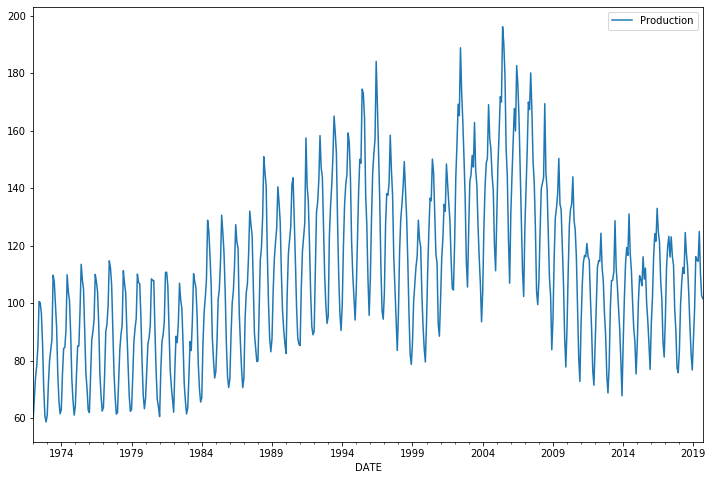

In [5]:
# Visualising data
data.plot(figsize=(12,8))
plt.show()

### Data Preprocessing

#### Splitting data

In [6]:
# I want 10% of the whole data has to be splitted to train and test
length = 0.1
split_length =len(data) -  int(len(data)*length)
train_data = data.iloc[:split_length]
test_data = data.iloc[split_length:]

len(train_data),len(test_data)

(516, 57)

#### Scaling data using MinMaxScaler

In [7]:
#scaling data
scaler = MinMaxScaler()
scale_train = scaler.fit_transform(train_data)
scale_test  = scaler.transform(test_data) 

#### Preparing Time series generator data for training as well as validation data

In [8]:
def timeserieGenerator(length=12,batch_size=1):
    train_generator = TimeseriesGenerator(scale_train,scale_train,length = length,batch_size = batch_size)
    
    validation_generator = TimeseriesGenerator(scale_test,scale_test,length = length,batch_size = batch_size)
    
    return train_generator,validation_generator,length

length = int(input("Enter the length:"))
batch_size = int(input("Enter Batch Size:"))

train_generator,validation_generator,length = timeserieGenerator(length,batch_size)


Enter the length:24
Enter Batch Size:1


### Building Model

In [9]:
def building_and_fitting_model(model_type,length=12,n_features = 1):
    
    
    model1 =  Sequential()
    model1.add(model_type(32,activation = 'relu',input_shape=(length,n_features)))
    model1.add(Dense(1))
    model1.compile(optimizer='adam',loss = 'mse')

    print(model1.summary())
    
    ES = EarlyStopping(monitor = 'val_loss',mode = 'min',patience=10)
    MC = ModelCheckpoint('D:/Model_checkpoint/',save_best_only = True,mode = 'min')
    
    model1.fit_generator(train_generator,validation_data = validation_generator,epochs = 300,callbacks = [ES,MC])
    
    print(str(model_type),":\n")
    df = pd.DataFrame(model1.history.history)
    df.plot()
    
    return model1

In [10]:

def forecast(to_be_forecasted,model):
    forecast = []
    first_eval_batch = scale_train[-length:]
    current_eval_batch = first_eval_batch.reshape((1,length,batch_size))
    
    for i in range(to_be_forecasted):
        
        prediction = model.predict(current_eval_batch)[0]
        forecast.append(prediction)
        current_eval_batch = np.append(current_eval_batch[:,1:,:],[[prediction]],axis=1)
        
    forecast = scaler.inverse_transform(forecast)
    
    return forecast
        
    
    
    

#### LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 492 steps, validate for 33 steps
Epoch 1/300
490/492 [============================>.] - ETA: 0s - loss: 0.0312WARNING:tensorflow:From C:\Users\RAGHAVENDRA\.conda\envs\tensorflow\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated an

C:\Users\RAGHAVENDRA\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


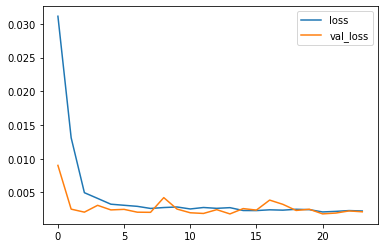

In [11]:
model_LSTM = building_and_fitting_model(LSTM,length = length , n_features = batch_size)
forecast_points = forecast(len(scale_test),model_LSTM)
test_data["LSTM"] = forecast_points


### SimpleRNN


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 492 steps, validate for 33 steps
Epoch 1/300
492/492 [==============================] - 18s 36ms/step - loss: 0.0276 - val_loss: 0.0040
Epoch 2/300
492/492 [==============================] - 17s 34ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 3/300
492/492 [==============================] - 11s 22ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 4/300
492/492 [==============================] - 13s 27ms/step - loss: 0.0025 - val_loss: 0.0028
Epoc

C:\Users\RAGHAVENDRA\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


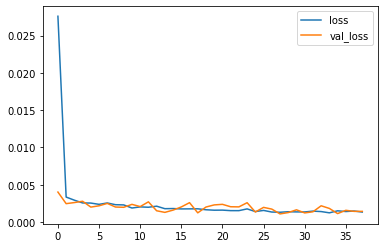

In [12]:
model_SRNN = building_and_fitting_model(SimpleRNN,length = length , n_features = batch_size)
forecast_points = forecast(len(scale_test),model_SRNN)
test_data["SimpleRNN"] = forecast_points


### GRU

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
None
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 492 steps, validate for 33 steps
Epoch 1/300
492/492 [==============================] - 22s 44ms/step - loss: 0.0242 - val_loss: 0.0074
Epoch 2/300
492/492 [==============================] - 27s 54ms/step - loss: 0.0102 - val_loss: 0.0046
Epoch 3/300
492/492 [==============================] - 27s 54ms/step - loss: 0.0075 - val_loss: 0.0040
Epoch 4/300
492/492 [==============================] - 25s 51ms/step - loss: 0.0061 - val_loss: 0.0036
Epoc

492/492 [==============================] - 13s 26ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 53/300
492/492 [==============================] - 15s 30ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 54/300
492/492 [==============================] - 16s 32ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 55/300
492/492 [==============================] - 12s 24ms/step - loss: 0.0019 - val_loss: 0.0019
<class 'tensorflow.python.keras.layers.recurrent_v2.GRU'> :



C:\Users\RAGHAVENDRA\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


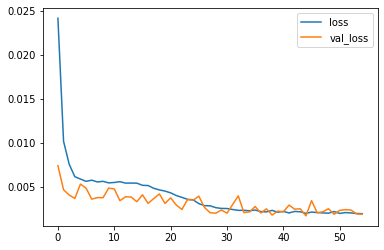

In [13]:
model_GRU = building_and_fitting_model(GRU,length = length , n_features = batch_size)
forecast_points = forecast(len(scale_test),model_GRU)
test_data["GRU"] = forecast_points


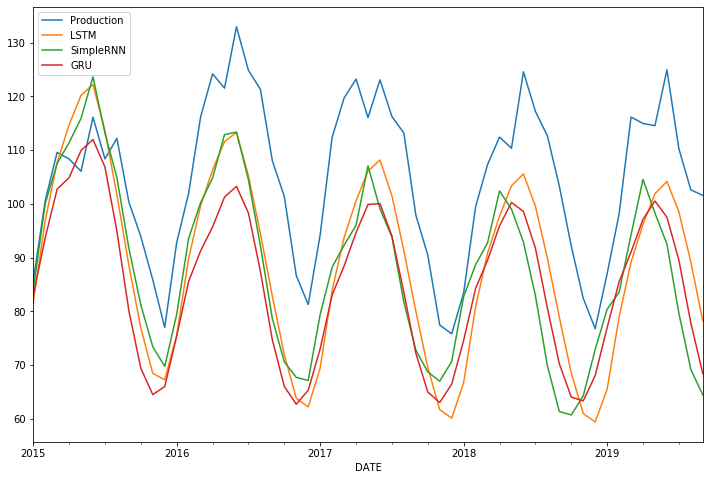

In [14]:
test_data.plot(figsize=(12,8))

### Evaluating model using reccursion metrics

In [15]:
test_data.columns

Index(['Production', 'LSTM', 'SimpleRNN', 'GRU'], dtype='object')

In [17]:
def max_error_value(true,predicted):
    return max_error(true,predicted)

def r2score(true,predicted):
    return r2_score(true,predicted)

def mean_squared_error_value(true,predicted):
    return mean_squared_error(true,predicted)

def mean_squared_error_value(true,predicted):
    return mean_squared_error(true,predicted)



def evaluating_models():
    #Printing Max Error
    data_first_coulmn = test_data[['Production']]
    
    print("Max Error from LSTM:",max_error_value(data_first_coulmn,test_data[['LSTM']]))
    print("Max Error from SimpleRNN:",max_error_value(data_first_coulmn,test_data[['SimpleRNN']]))
    print("Max Error from GRU:",max_error_value(data_first_coulmn,test_data[['GRU']]))
    print("\n\n")
    #Mean Squared Error
    print("Mean Squared Error from LSTM: ",mean_squared_error_value(data_first_coulmn,test_data[['LSTM']]))
    print("Mean Squared Error from SimpleRNN: ",mean_squared_error_value(data_first_coulmn,test_data[['SimpleRNN']]))
    print("Mean Squared Error from GRU: ",mean_squared_error_value(data_first_coulmn,test_data[['GRU']]))
    print("\n\n")
    #r2_score
    rscr = 0
    model = 'LSTM'
    
    #LSTM
    rscr = r2score(data_first_coulmn,test_data[['LSTM']])
    print("r2_score From LSTM:",rscr)
    
    #SimpleRNN
    temp = r2score(data_first_coulmn,test_data[['SimpleRNN']])
    print("r2_score From SimpleRNN:",temp)
    
    if temp>rscr:
        rscr = temp
        model = 'SimpleRNN'
        
    #GRU    
    temp = r2score(data_first_coulmn,test_data[['GRU']])
    print("r2_score From GRU:",temp)
    
    if temp>rscr:
        rscr = temp
        model = 'GRU'
        
    print('\n\nBest Model Among All Is: "',model ,'"  With r2_score: ',rscr)
    
evaluating_models()
        
    

Max Error from LSTM: 29.457631430004554
Max Error from SimpleRNN: 42.79126983497591
Max Error from GRU: 35.36951318000294



Mean Squared Error from LSTM:  330.2266166720339
Mean Squared Error from SimpleRNN:  431.91542600678525
Mean Squared Error from GRU:  478.0447846168485



r2_score From LSTM: -0.5406163882024566
r2_score From SimpleRNN: -1.0150283170068017
r2_score From GRU: -1.230237032064779


Best Model Among All Is: " LSTM "  With r2_score:  -0.5406163882024566


##### Based on the above, we are using SimpleRNN for predicting or forecasting for an year's data

### Forecasting results with the trained model of SimpleRNN

##### Note: More and more you forecast,introducing of noise is too much into data.

In [18]:
scaled_data_for_forecasting = scaler.fit_transform(data)

In [19]:
train_data.tail()

,Production
DATE,
2014-08-01,111.4180
2014-09-01,100.6174
2014-10-01,91.2615
2014-11-01,86.5723
2014-12-01,75.3749


In [20]:
period = int(input('Enter the number of years to be forecasted:'))
period *= 12
forecasting_result = forecast(period,model_LSTM)

Enter the number of years to be forecasted:5


In [21]:
forecating_index = pd.date_range(start='2015-01-01',periods=period,freq='MS')
forecating_index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
      

In [22]:
forecast_dataframe = pd.DataFrame(data = forecasting_result,index = forecating_index,
                                 columns = ['Forecast'])

In [23]:
# Forecasted dataframe
forecast_dataframe

,Forecast
2015-01-01,81.588388
2015-02-01,96.803187
2015-03-01,107.704218
2015-04-01,114.703956
2015-05-01,120.202273
2015-06-01,122.245996
2015-07-01,113.586978
2015-08-01,101.706100
2015-09-01,88.613814
2015-10-01,76.900462


##### plotting in different plots

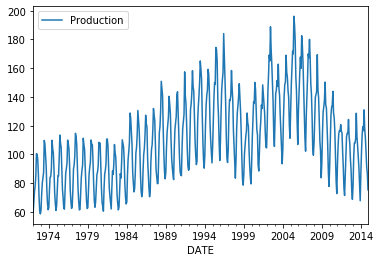

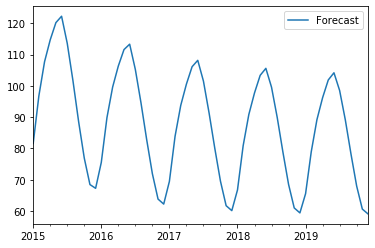

In [24]:
train_data.plot()
forecast_dataframe.plot()

##### Plotting in same axis

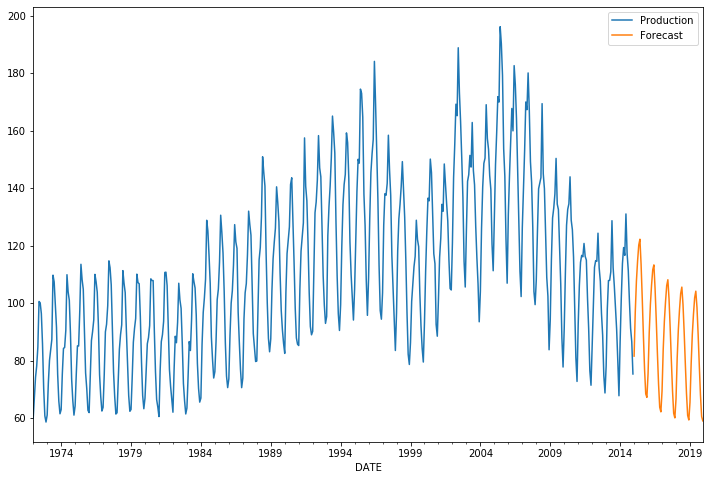

In [25]:
ax = train_data.plot(figsize=(12,8))
forecast_dataframe.plot(ax=ax)
#plt.xlim('2010-07-01','2019-12-01')

(474, 599)

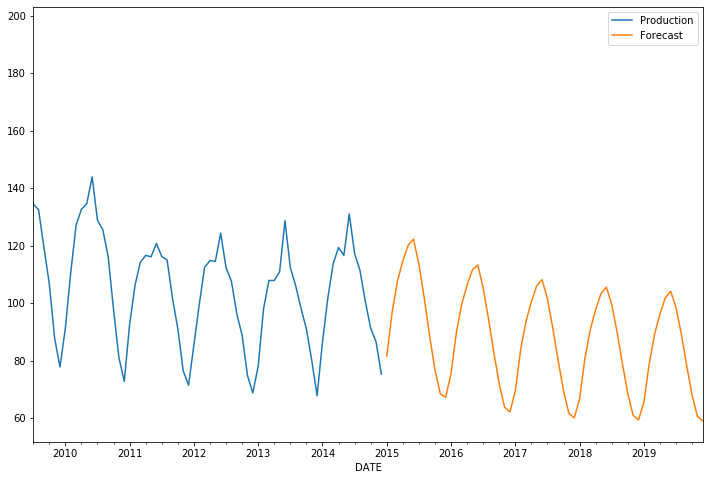

In [26]:
ax = train_data.plot(figsize=(12,8))
forecast_dataframe.plot(ax=ax)
plt.xlim('2009-07-01','2019-12-01')